In [2]:
import twopTools as tpt
import h5py
import numpy as np
import os
import datetime
import numpy as np
import scipy.stats
import oasis
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

def read_xml(xml_path):

    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Get the number of frames in the image stack
    nF = len(list(tree.find('Sequence')))


    # Absolute and relative times
    # Absolute are offset from the first timestamp by ~10 seconds
    absoluteT = np.zeros([nF], dtype=float)
    relativeT = np.zeros([nF], dtype=float)
    
    # Name of the file for each frame
    fnames = np.zeros([nF], dtype=str)

    # Iterate through the xml file and get the absolute and relative times
    for child in list(root.find('Sequence')):
        if child.tag != 'Frame':
            continue
        i = int(child.attrib['index'])-1

        _f = child.find('File').attrib['filename']

        absoluteT[i] = float(child.attrib['absoluteTime'])
        relativeT[i] = float(child.attrib['relativeTime'])
        fnames[i] = _f

    # Get the month, day and year from the xml file. This will be a
    # list of strings
    mdy = [int(x) for x in root.get('date').split(' ')[0].split('/')]

    # Get the starttime of the recording
    t0_str = root.find('Sequence').attrib['time']
    # Format that string into a datetime object with the correct day, month
    # and year, instead of the 1/1/1900 that it is create with by default
    t0 = (
        datetime.datetime.strptime(t0_str[:-1], '%H:%M:%S.%f')
        - datetime.datetime(year=1900, month=1, day=1)
        + datetime.datetime(mdy[2], mdy[0], mdy[1])
    )
    
    abs_2P_timestamps = absoluteT
    rel_2P_timestamps = relativeT
    num_2P_frames = nF
    
    # all_PVState_items = {}
    for i, child in enumerate(list((root.find('PVStateShard')))):
        child_items = [item for item in child.items()]
        if len(child_items) > 0:
            k = child_items[0][1]
            if k == 'framePeriod':
                acq_Hz = 1 / float(child_items[1][1])
            elif k == 'opticalZoom':
                optical_zoom = float(child_items[1][1])
            elif k == 'laserPower':
                laser_pockels = float(child[0].items()[1][1])
            elif k == 'laserWavelength':
                laser_wavelengths = float(child[0].items()[1][1])
            elif k == 'linesPerFrame':
                lines_per_frame = float(child.items()[1][1])
            elif k == 'micronsPerPixel':
                umPerPix_X = child[0].items()[1][1]
                umPerPix_Y = child[1].items()[1][1]
                umPerPix_Z = child[2].items()[1][1]
            elif k == 'pmtGain':
                pmt1_gain = child[0].items()[1][1]
                pmt2_gain = child[1].items()[1][1]
            elif k == 'positionCurrent':
                stage_position_X = child[0][0].items()[1][1]
                stage_position_Y = child[1][0].items()[1][1]
                stage_position_Z = child[2][0].items()[1][1]

    acq_props = {
        't0': t0,
        'abs_time': abs_2P_timestamps,
        'rel_time': rel_2P_timestamps,
        'num_frames': num_2P_frames,
        'acq_Hz': acq_Hz,
        'optical_zoom': optical_zoom,
        'laser_pockels': laser_pockels,
        'laser_wavelength': laser_wavelengths,
        'lines_per_frame': lines_per_frame,
        'um_per_pix_X': umPerPix_X,
        'um_per_pix_Y': umPerPix_Y,
        'um_per_pix_Z': umPerPix_Z,
        'pmt1_gain': pmt1_gain,
        'pmt2_gain': pmt2_gain,
        'stage_position_X': stage_position_X,
        'stage_position_Y': stage_position_Y,
        'stage_position_Z': stage_position_Z
    }

    return acq_props


def time2float(timearr, rel=None):
    """ Convert datetime to float.

    Parameters
    ----------
    timearr : np.array
        Array of datetime objects.
    rel : datetime.datetime, optional
        If not None, the returned array will be relative
        to this time. The default is None, in which case the
        returned float values will be relative to the first
        time in timearr (i.e. start at 0 sec).
    
    Returns
    -------
    out : np.array
        Array of float values representing the time in seconds.
    
    """
    if rel is None:
        return [t.total_seconds() for t in (timearr - timearr[0])]
    elif rel is not None:
        if type(rel)==list or type(rel)==np.ndarray:
            rel = rel[0]
            rel = datetime.datetime(year=rel.year, month=rel.month, day=rel.day)
        return [t.total_seconds() for t in timearr - rel]
    

def find_closest(arr, target):
    return np.nanargmin(np.abs(arr-target))

In [9]:
filename = r'K:\JSY038_RFTuning\250124_JSY_JSY038_RFTuning_stimframes.mat'
f = h5py.File(filename)

img_arr = f['noise_image'][:]


spikes_path = r'K:\JSY038_RFTuning\250124_JSY_JSY038_RFTuning\TSeries-01242025-1521-001\suite2p\plane0\spks.npy'
iscell_path = r'K:\JSY038_RFTuning\250124_JSY_JSY038_RFTuning\TSeries-01242025-1521-001\suite2p\plane0\iscell.npy'

iscell = np.load(iscell_path)
usecells = iscell[:,0]==1

spikes = np.load(spikes_path)
usespikes = spikes[usecells,:]

nF = np.size(spikes, 1)

cell0 = spikes[0,:].copy()


xml_path = r'K:\JSY038_RFTuning\250124_JSY_JSY038_RFTuning\TSeries-01242025-1521-001\TSeries-01242025-1521-001.xml'
xml_dict = read_xml(xml_path)
t0 = xml_dict['t0']
abs_time = xml_dict['abs_time']

twopT = np.zeros(np.size(abs_time,0)-1, dtype=datetime.datetime)
for i, t in enumerate(abs_time[:-1]):
    twopT[i] = t0 + datetime.timedelta(seconds=t)

twopT_float = time2float(twopT)

stim_on_time = 2.
isi_time = 4.
n_repeats = 200

stim_onsets = np.arange(0, twopT_float[-1], stim_on_time + isi_time)
isi_onsets = stim_onsets.copy() + isi_time

isi_arr = np.zeros([
    np.size(img_arr,0)*2,
    np.size(img_arr,1),
    np.size(img_arr,2)
])
stim_arr = np.concatenate([img_arr, isi_arr])

full_stim_video = np.zeros([
    np.size(stim_arr,0)*n_repeats,
    np.size(stim_arr,1),
    np.size(stim_arr,2)
])

for rep in range(n_repeats):
    start_ind = np.size(stim_arr,0) * rep
    end_ind = (np.size(stim_arr,0) * rep) + np.size(stim_arr,0)
    # print(rep, start_ind, end_ind)
    full_stim_video[start_ind:end_ind, :, :] = stim_arr.copy()

stim_time = np.linspace(0, twopT_float[-1], np.size(full_stim_video, 0))

nCells = np.size(usespikes,0)
cell_infill = np.zeros([
    nCells,
    len(stim_time),
])

for c in range(nCells):
    for i in range(np.size(cell_infill,0)):
        cell_infill[c, (i*6):(i*6)+6] = usespikes[c,i]
# cell_infill_reshape = cell_infill[np.newaxis, :]

In [11]:
cell_infill.shape

(798, 72000)

In [12]:
sta = tpt.calc_spike_triggered_avg(cell_infill, full_stim_video, lags='zero', variance=False)

In [13]:
sta.shape

(798, 1, 128, 128)

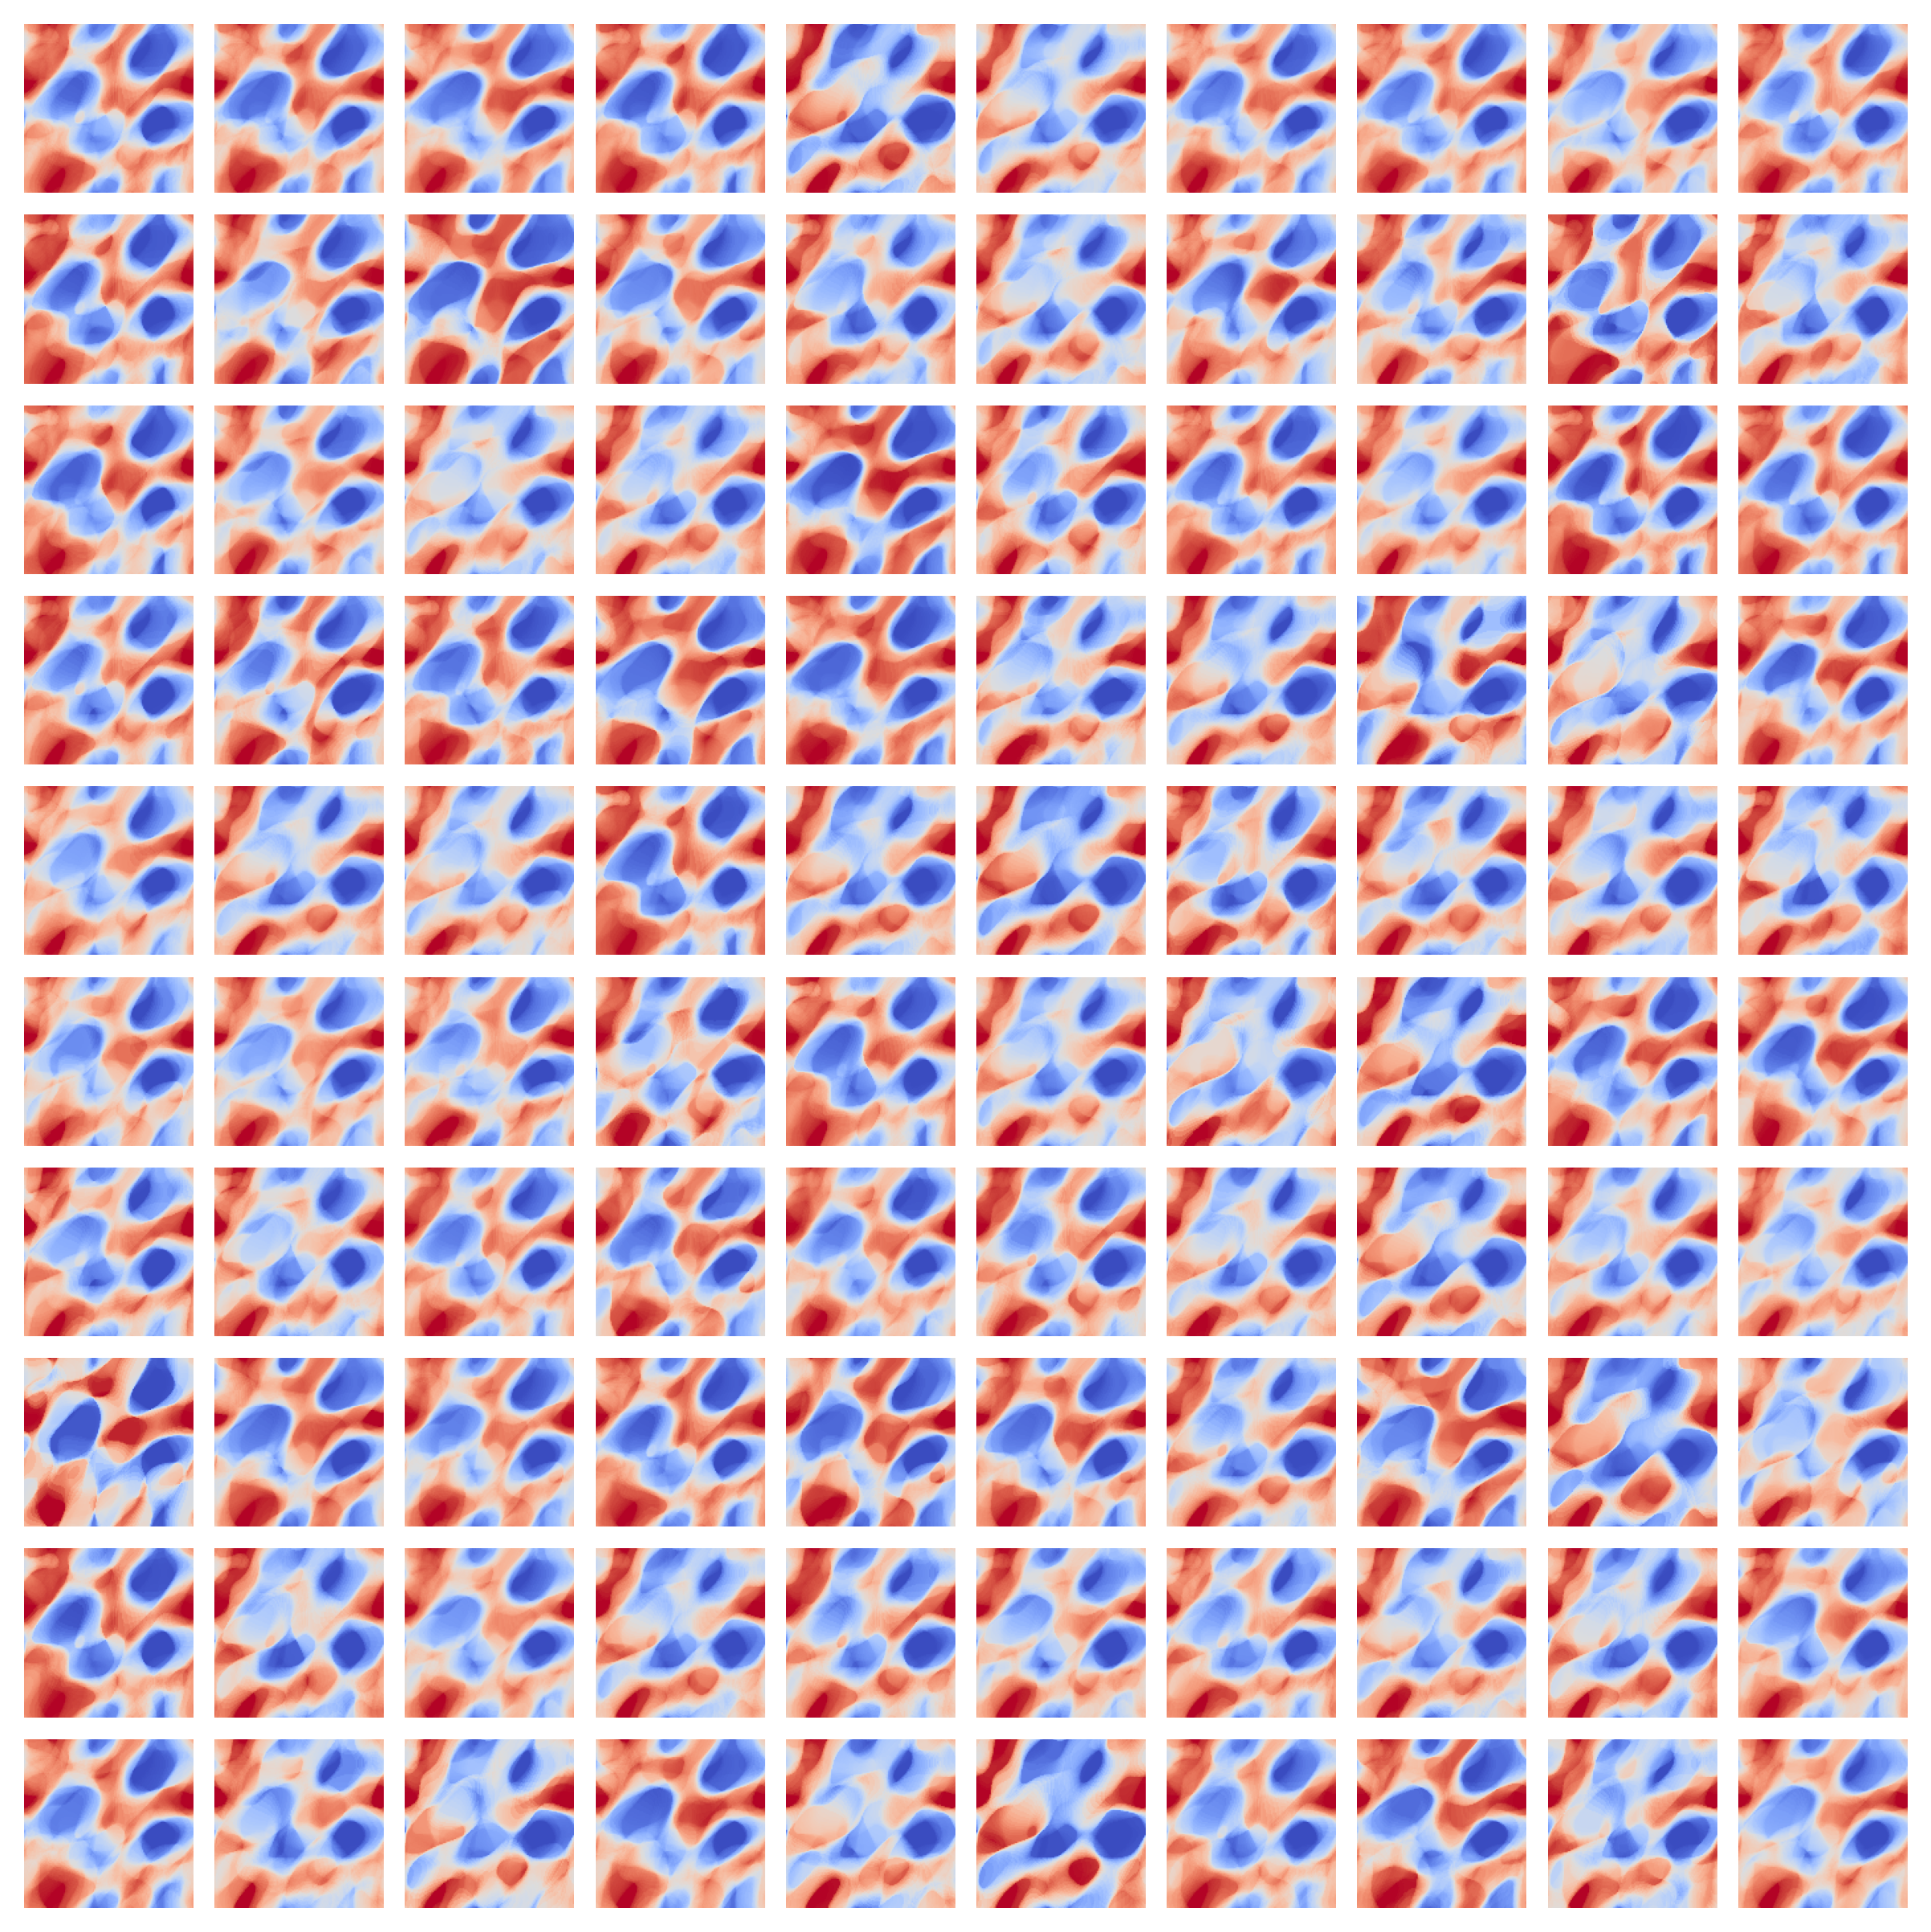

In [21]:
fig, axs = plt.subplots(10,10, dpi=300, figsize=(8,8))
axs = axs.flatten()
for i in range(100):
    axs[i].imshow(sta[i,0,:,:], cmap='coolwarm')
    axs[i].axis('off')
fig.tight_layout()

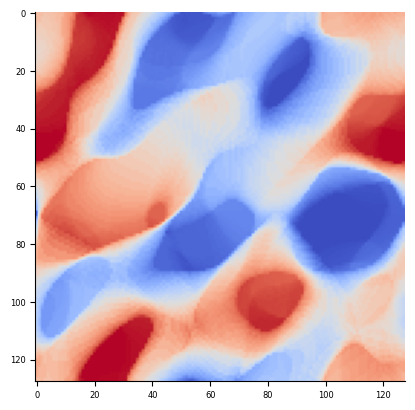

In [18]:
plt.imshow(sta[4,0,:,:], cmap='coolwarm')